In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.special import digamma

Make simulation data

In [189]:
np.random.seed(4428)
y = np.concatenate([np.random.poisson(lam = 1,size =30),np.random.poisson(lam = 3,size =70)])
y = y.astype('float')

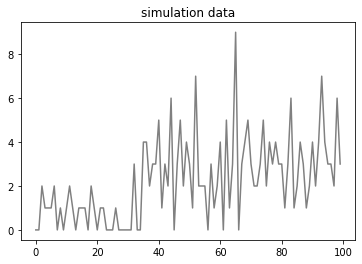

In [190]:
plt.title('simulation data')
plt.plot(y,color='gray')
plt.show()

Gibbs approach

In [191]:
def sample_lamb(pi,k,y,a,b):
    return np.random.gamma(shape = a + y[:k].sum(),scale =1/(k+b), size = 1)[0]
    
def sample_pi(lam,k,y,c,d):
    n= len(y)
    return np.random.gamma(shape = c + y[k:].sum(),scale =1/(n-k+d), size = 1)[0]

def sample_k(lam,pi,y):
    p = np.repeat(0.,len(y))
    for k in range(1,(len(y)+1)):
        p[k-1] = np.exp(k*(pi-lam) + np.log(lam/pi)* (y[:(k-1)].sum()))
    prop = p/p.sum()
    return (np.random.choice(len(y), 1, p=prop)[0] + 1 )

def acf(sampl,lag =40):
    sampl = np.array(sampl)
    base = sampl.dot(sampl)/len(sampl)
    acr = [1]
    for t in range(1,lag):
        acr.append((sampl[t:].dot(sampl[:-t])/(len(sampl)-t))/base)
    x = list(range(lag))
    plt.bar(x,acr,color='gray')
    plt.title('Autocorrelation plot')
    plt.hlines(0.05,xmin=-0.5 ,xmax=lag,colors='r',linestyles='dashed')
    plt.hlines(-0.05,xmin=-0.5 ,xmax=lag,colors='r',linestyles='dashed')
    #plt.show()

In [192]:
a = 4
b = 1
c = 1
d = 2

pi = 1
k = 1

lamlst = []
pilst = []
klst = []
for iteration in range(10000):
    
    lam = sample_lamb(pi,k,y,a,b)
    pi = sample_pi(lam,k,y,c,d)
    k = sample_k(lam,pi,y)
    
    lamlst.append(lam)
    pilst.append(pi)
    klst.append(k)

In [205]:
def plot_giibs(lst,title):
    plt.figure(figsize = (25,5))
    plt.suptitle(title)
    plt.subplot(131)
    plt.title('ts plot')
    plt.plot(lst,color='gray')
    plt.subplot(132)
    plt.title('histogram')
    plt.hist(lst,color='gray')
    plt.subplot(133)
    acf(np.array(lst) - np.array(lst).mean())
    plt.show()

In [206]:
def plot_giibs_k(lst,title):
    plt.figure(figsize = (25,5))
    plt.suptitle(title)
    plt.subplot(131)
    plt.title('ts plot')
    plt.plot(lst,color='gray')
    plt.subplot(132)
    plt.title('histogram')
    plt.hist(lst,color='gray',bins=100)
    plt.subplot(133)
    acf(np.array(lst) - np.array(lst).mean())
    plt.show()

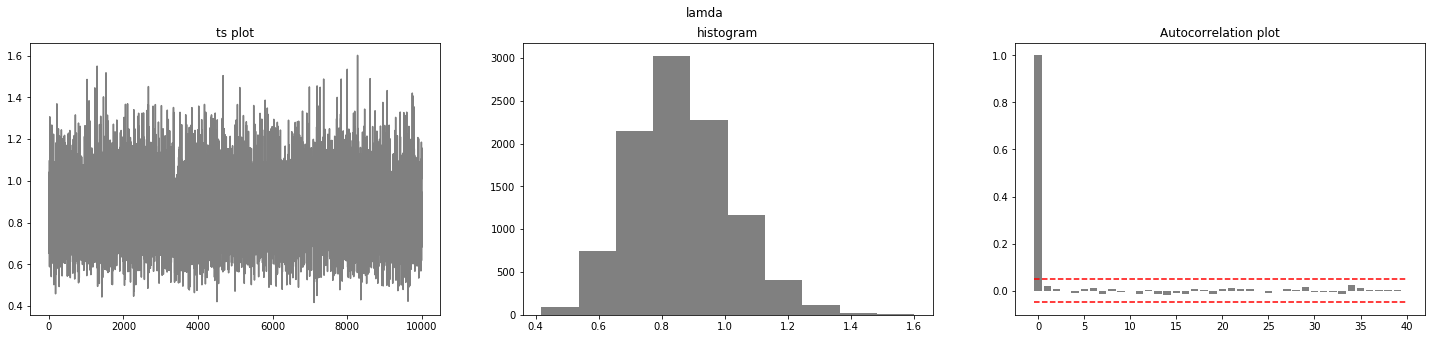

In [207]:
plot_giibs(lamlst,'lamda')

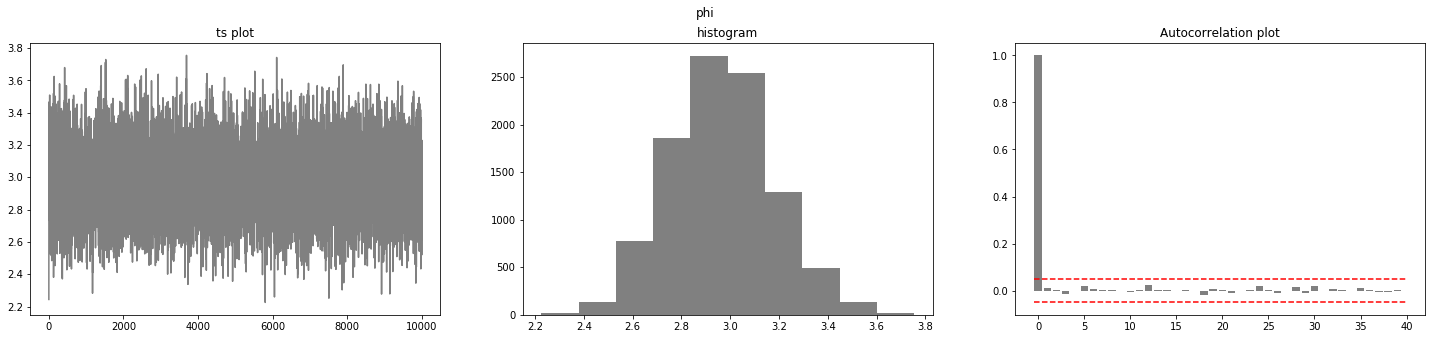

In [208]:
plot_giibs(pilst,'phi')

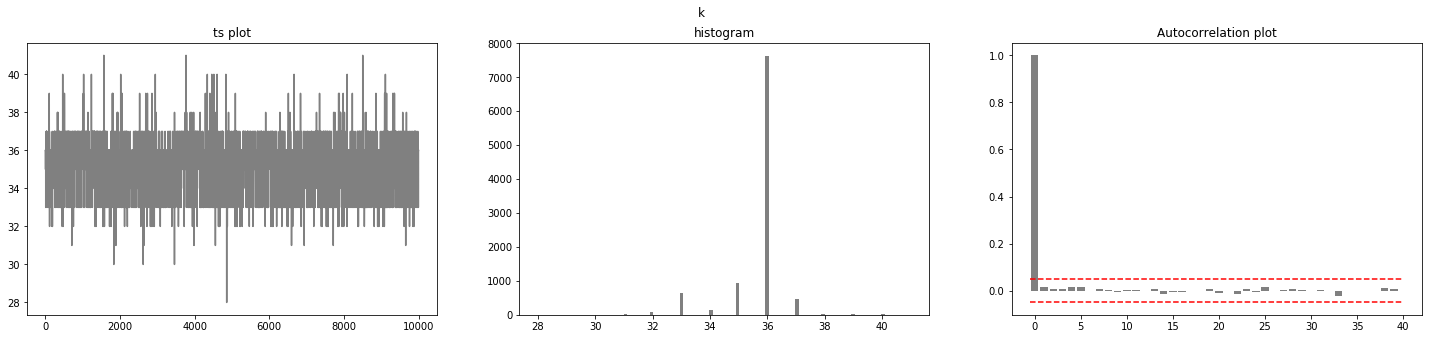

In [209]:
plot_giibs_k(klst,'k')

Variational Inference

In [198]:
a = 4
b = 1
c = 1
d = 2

expected_k = 50
niter = 1000

for iteration in range(niter):

    al_lam = a + y[0:int(round(expected_k))].sum()
    be_lam = b + expected_k
    expected_lam = al_lam/be_lam
    expected_loglam = -np.log(be_lam) + digamma(al_lam)
    
    al_phi = c +y[int(round(expected_k)):len(y)].sum()
    be_phi = d + len(y) - expected_k
    expected_phi = al_phi/be_phi
    expected_logphi =  -np.log(be_phi) + digamma(al_phi)
    
    prop = np.repeat(0.,len(y))
    for k in range(len(y)):
        prop[k] = np.exp((k+1)*(expected_phi-expected_lam) + (expected_loglam- expected_logphi)*(y[:k].sum()))
    p = prop / prop.sum()
    expected_k = (p * np.arange(1,(len(y)+1))).sum()

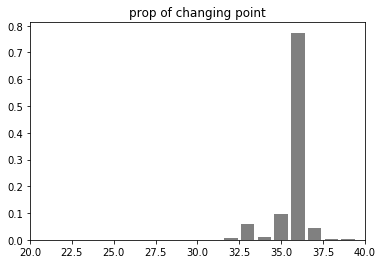

In [210]:
plt.title('prop of changing point')
plt.bar(x= np.arange(1,len(y)+1),height=p,color='gray')
plt.xlim(20,40)
plt.show()

In [200]:
expected_k

35.720435449164086

(array([  56.,  568., 1889., 2886., 2483., 1451.,  494.,  139.,   31.,
           3.]),
 array([0.41709488, 0.53216222, 0.64722957, 0.76229691, 0.87736425,
        0.9924316 , 1.10749894, 1.22256628, 1.33763363, 1.45270097,
        1.56776832]),
 <a list of 10 Patch objects>)

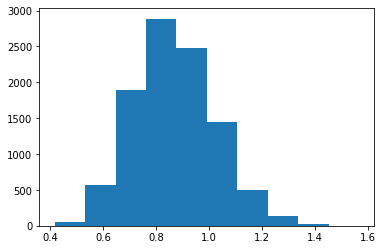

In [215]:
plt.hist(np.random.gamma(al_lam,1/be_lam,10000))

(array([  34.,  254., 1019., 2365., 2903., 2118.,  970.,  275.,   55.,
           7.]),
 array([2.25105007, 2.40895834, 2.56686661, 2.72477488, 2.88268315,
        3.04059142, 3.19849968, 3.35640795, 3.51431622, 3.67222449,
        3.83013276]),
 <a list of 10 Patch objects>)

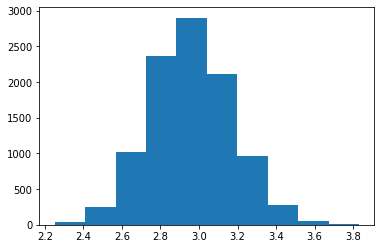

In [214]:
plt.hist(np.random.gamma(al_phi,1/be_phi,10000))

(196.0, 66.27956455083591)